In [1]:
import numpy as np
from skyfield.api import load, Topos
import matplotlib.pyplot as plt

In [2]:
# Load ephemeris data
eph = load('de421.bsp')
earth, moon, sun = eph['earth'], eph['moon'], eph['sun']

ts = load.timescale()

#Calculation of the angular distance in equatorial coordinates
def angular_distance(ra1, dec1, ra2, dec2):
    ra1 = np.deg2rad(ra1 * 15)  # Convert hours to degrees
    ra2 = np.deg2rad(ra2 * 15)  # Convert hours to degrees
    dec1 = np.deg2rad(dec1)
    dec2 = np.deg2rad(dec2)
    cos_distance = np.sin(dec1) * np.sin(dec2) + np.cos(dec1) * np.cos(dec2) * np.cos(ra1 - ra2)
    distance = np.arccos(cos_distance)
    return np.rad2deg(distance)

#Only 3 months starting March 21st and ending June 20th (23 days in total)
d_3 = np.arange(21,32,4)
d_4 = np.arange(2,31,4)
d_5 = np.arange(4,32,4)
d_6 = np.arange(1,21,4)

In [3]:
from skyfield.api import EarthSatellite

#Ideal Satellite
line1_ideal = '1 00001U 20001A   24094.87500000  .00000000  00000-0  00000-0 0  0000'
line2_ideal = '2 00001   0.0000  0.0000 0000000  0.0000  0.0000  1.00000000  00000' # exactly 1 rev. per day
satellite_ideal = EarthSatellite(line1_ideal, line2_ideal, 'Ideal Satellite', ts)

This version is the current one, meaning that we calculate every 4th day and for every day every 30min. Also the safe position tests includes the points that are observable for 2 consecutive times. And the fields in the end are with distortion:

In [4]:
# The "containers" for all the equatorial coord values for the moon, earth and sun (order: RA, Dec)
moon_eq_values_24 = []
sun_eq_values_24 = []
earth_eq_values_24 = []

# Generate a grid of RA and Dec values
ra_grid = np.linspace(0, 24, 360)  # RA from 0 to 24 hours
dec_grid = np.linspace(-90, 90, 180)  # Dec from -90 to 90 degrees

In [5]:
# Function to check if there are at least 2 consecutive valid time steps (equals 30min)
def has_consecutive_times(times, n=2):
    times = sorted(times)
    for i in range(len(times) - n + 1):
        if times[i + n - 1] - times[i] == n - 1:
            return True
    return False

__Moon__

First we go with the moon and the constraint it implies: (THIS IS AN OLD VERSION WHERE WE STILL OBSERVED FROM THE EARTH AND NOT THE SATELLITE)

In [17]:
# Trajectory of the moon every 30 minutes for 6 months every 4th day starting June 21st
for i in np.arange(6,10): # from June til September
    var = f'd_{i}'
    var_2 = globals()[var]
    for d in var_2:
        for h in np.arange(0,24):
            for m in np.arange(0,60,30):
                t = ts.utc(2024, i, d, h, m)
                astrometric = observer.at(t).observe(moon)
                ra, dec, distance = astrometric.radec()
                moon_eq_values_24.append((ra.hours, dec.degrees)) 
        t = ts.utc(2024, i, d, 23, 59)
        astrometric = observer.at(t).observe(moon)
        ra, dec, distance = astrometric.radec()
        moon_eq_values_24.append((ra.hours, dec.degrees))

NameError: name 'observer' is not defined

Safe sky positions for the moon:

In [ ]:
# Splitting the positions into lists of 49 bc for one day positions are calculated 49 times
day_size = 49
moon_daysplit = [moon_eq_values_24[i:i + day_size] for i in range(0, len(moon_eq_values_24), day_size)]

In [ ]:
# Main loop to check for safe RA-Dec combinations
safe_coord_24_moon = []

for ra in ra_grid:
    for dec in dec_grid:
        is_safe = True
        
        for d in np.arange(0, 23):  # Loop over days
            t = 0  # time step counter
            safe_t = []  # list for the safe time steps
            
            # Apply moon constraint
            for moon_ra, moon_dec in moon_daysplit[d]:
                if angular_distance(ra, dec, moon_ra, moon_dec) >= 35:
                    safe_t.append(t)
                t += 1
            
            # If there are fewer than 2 valid time steps, break early
            if len(safe_t) < 2:
                is_safe = False
                break
            
            
            # Check if there are at least 2 consecutive valid time steps
            if not has_consecutive_times(safe_t, n=2):
                is_safe = False
                break
        
        # If the ra-dec pair is safe for all days, add it to the list
        if is_safe:
            safe_coord_24_moon.append((ra, dec))
            
safe_ra_24_moon = [x[0] for x in safe_coord_24_moon]
safe_dec_24_moon = [y[1] for y in safe_coord_24_moon]

# Plot the results
plt.figure(figsize=(10, 5))
plt.scatter(safe_ra_24_moon, safe_dec_24_moon, s=1, label='Safe Positions Moon')
plt.xlim(0, 24)
plt.ylim(-90, 90)
plt.xlabel('RA (hours)')
plt.ylabel('Dec (degrees)')
plt.title('Safe Positions Moon Jun-Sep')
plt.legend()
plt.show()

#plt.savefig('all_3m_spring_final', dpi=400)

I want to see if the safe sky regions change visibly/significantly when I switch to the observation from the satellite. In the end that is just one more word in the code, but it would mean a more precise result, but I'd had to change that everywhere and rerun the code and maybe adjust the fields a little bit. ( For the sun I am pretty sure that the difference wont be visible in the data in any significant result). OBSERVATION FROM SATELLITE

In [6]:
moon_eq_values_sat = []

# Trajectory of the moon every 30 minutes for 6 months every 4th day starting March 21st
for i in np.arange(3,7): # from March tilJune
    var = f'd_{i}'
    var_2 = globals()[var]
    for d in var_2:
        for h in np.arange(0,24):
            for m in np.arange(0,60,30):
                t = ts.utc(2024, i, d, h, m)
                astrometric = (earth + satellite_ideal).at(t).observe(moon)
                ra, dec, distance = astrometric.radec()
                moon_eq_values_sat.append((ra.hours, dec.degrees)) 
        t = ts.utc(2024, i, d, 23, 59)
        astrometric = (earth + satellite_ideal).at(t).observe(moon)
        ra, dec, distance = astrometric.radec()
        moon_eq_values_sat.append((ra.hours, dec.degrees))

In [7]:
day_size = 49
moon_sat_daysplit = [moon_eq_values_sat[i:i + day_size] for i in range(0, len(moon_eq_values_sat), day_size)]

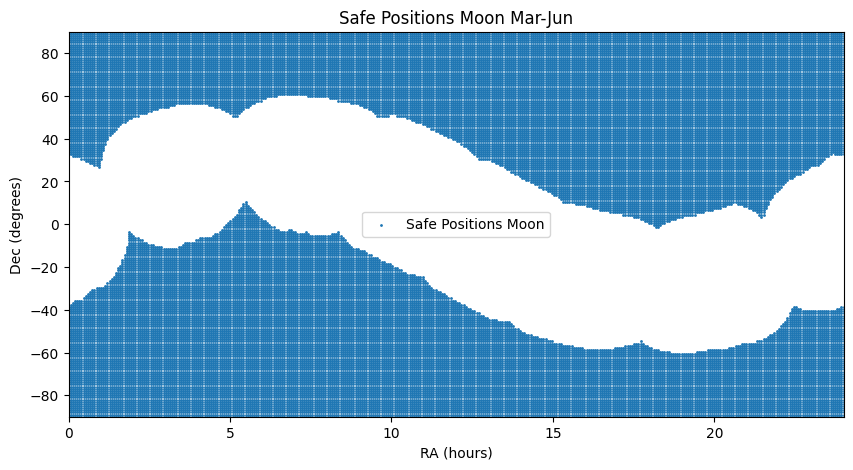

In [8]:
# Main loop to check for safe RA-Dec combinations
safe_coord_sat_moon = []

for ra in ra_grid:
    for dec in dec_grid:
        is_safe = True
        
        for d in np.arange(0, 23):  # Loop over days
            t = 0  # time step counter
            safe_t = []  # list for the safe time steps
            
            # Apply moon constraint
            for moon_ra, moon_dec in moon_sat_daysplit[d]:
                if angular_distance(ra, dec, moon_ra, moon_dec) >= 35:
                    safe_t.append(t)
                t += 1
            
            # If there are fewer than 2 valid time steps, break early
            if len(safe_t) < 2:
                is_safe = False
                break
            
            
            # Check if there are at least 2 consecutive valid time steps
            if not has_consecutive_times(safe_t, n=2):
                is_safe = False
                break
        
        # If the ra-dec pair is safe for all days, add it to the list
        if is_safe:
            safe_coord_sat_moon.append((ra, dec))
            
safe_ra_sat_moon = [x[0] for x in safe_coord_sat_moon]
safe_dec_sat_moon = [y[1] for y in safe_coord_sat_moon]

# Plot the results
plt.figure(figsize=(10, 5))
plt.scatter(safe_ra_sat_moon, safe_dec_sat_moon, s=1, label='Safe Positions Moon')
plt.xlim(0, 24)
plt.ylim(-90, 90)
plt.xlabel('RA (hours)')
plt.ylabel('Dec (degrees)')
plt.title('Safe Positions Moon Mar-Jun')
plt.legend()
plt.show()

#plt.savefig('all_3m_spring_final', dpi=400)

NameError: name 'safe_ra_24_moon' is not defined

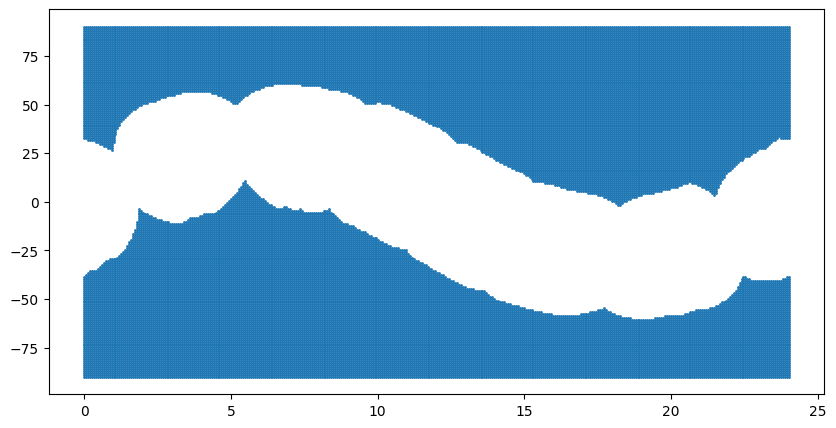

In [21]:
# Laying the surface version over the satellite version
fig = plt.figure(figsize=(10, 5))
plt.scatter(safe_ra_sat_moon, safe_dec_sat_moon, s=1, label='Sat')
plt.scatter(safe_ra_24_moon, safe_dec_24_moon, s=1, label='Surface')
plt.xlim(0, 24)
plt.ylim(-90, 90)
plt.xlabel('RA (hours)')
plt.ylabel('Dec (degrees)')
plt.title('Sat vs Surface')
plt.legend()
plt.show()

THIS MEANS THE OBSERVATION FROM THE SATELLITE SHOULD BE IMPLEMENTED FOR EVERY CONSTRAINT, BUT THIS IS ALREADY DONE

Now we want to see how the moon constraints look on the SFD98 map:

In [22]:
!pip install healpy

Defaulting to user installation because normal site-packages is not writeable


<Figure size 1000x500 with 0 Axes>

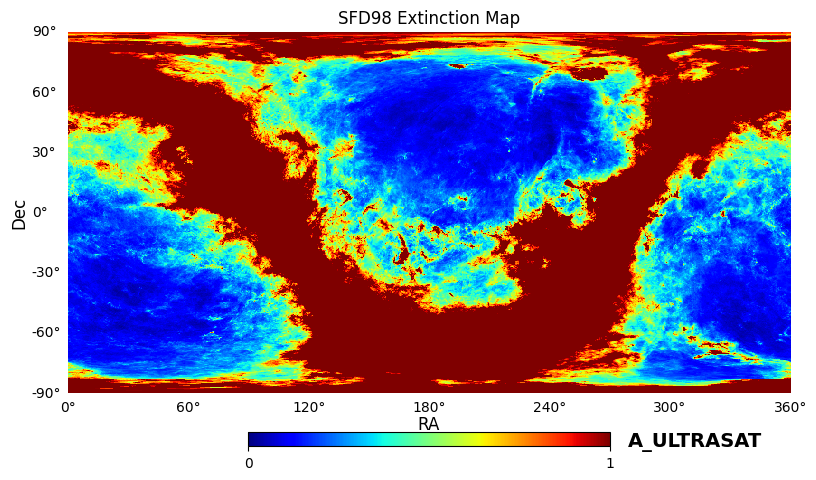

In [43]:
import healpy as hp
import matplotlib.pyplot as plt

# Replace this with the path to your lambda_sfd_ebv.fits file, source: https://lambda.gsfc.nasa.gov/product/foreground/fg_sfd_get.html
sfd_file = 'lambda_sfd_ebv.fits'

# Load the HEALPix data
ebv_map = hp.read_map(sfd_file, hdu=1)

# Create a figure with specific aspect ratio (width=2xheight)
fig = plt.figure(figsize=(10, 5))

# Plot the SFD98 extinction map
hp.cartview(6.7*ebv_map, coord=['G', 'C'], title="SFD98 Extinction Map", cmap='jet', unit='A_ULTRASAT', min=0, max=1, notext=True)

# Flip the plot upside down because for some reason the data is upside down
plt.gca().invert_yaxis()

# I think plot also needs to be flipped along the x-axis
plt.gca().invert_xaxis()

# Add manual labels for Right Ascension (x-axis)
plt.text(0.5, -0.1, 'RA', ha='center', fontsize=12, transform=plt.gca().transAxes)

# Add manual labels for Declination (y-axis)
plt.text(-0.08, 0.5, 'Dec', va='center', rotation='vertical', fontsize=12, transform=plt.gca().transAxes)

# Add RA ticks manually
for ra, label in zip([0, 60, 120, 180, 240, 300, 360], ['0°', '60°', '120°', '180°', '240°', '300°', '360°']):
    plt.text(ra/360, -0.05, label, ha='center', transform=plt.gca().transAxes)

# Add Dec ticks manually
for dec, label in zip([-90, -60, -30, 0, 30, 60, 90], ['-90°', '-60°', '-30°', '0°', '30°', '60°', '90°']):
    plt.text(-0.05, (dec+90)/180, label, va='center', transform=plt.gca().transAxes)

# Show the plot
plt.show()

First we still need to convert the moon RA values from hours into degrees:

In [24]:
safe_ra_deg_moon = [element * 15 for element in safe_ra_sat_moon]

safe_coord_deg_moon = list(zip(safe_ra_deg_moon, safe_dec_sat_moon)) # Creating a new list where both RA and Dec are in degrees

<Figure size 1000x500 with 0 Axes>

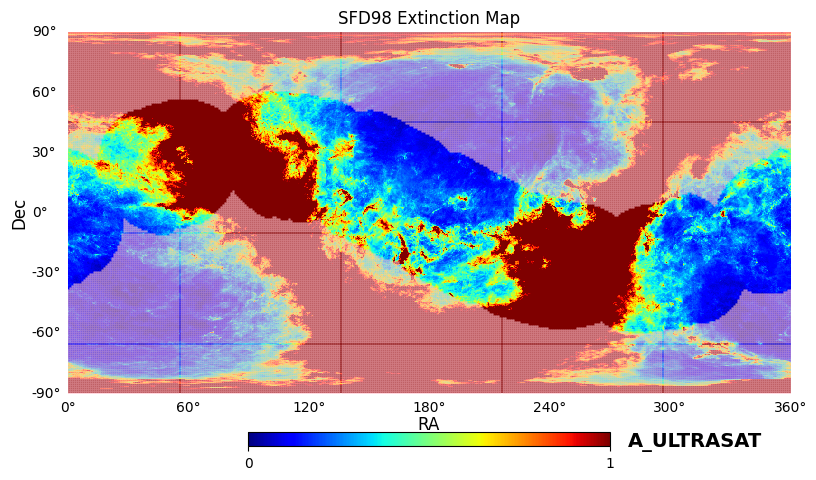

In [44]:
# Convert RA/Dec (theta, phi) to Healpy pixel indices
safe_dec_nparray_moon = np.array(safe_dec_sat_moon) # Converting the Dec points into np.array
safe_dec_nparray_moon = -safe_dec_nparray_moon # Inverting at the x axis, to match the new coordinate system
safe_ra_nparray_moon = np.array(safe_ra_deg_moon) # Converting the RA points into an np.array
ra_data_wrapped_moon = safe_ra_nparray_moon -180 # Switching to a system where RA ranges from -180° to 180°
ra_data_wrapped_moon = -ra_data_wrapped_moon # Inverting at the y axis because we also need to flip the other data later on

# Plot the overlapped map using `cartview` in Equatorial coordinates
fig = plt.figure(figsize=(10, 5))

# Plot the SFD98 extinction map
hp.cartview(6.7*ebv_map, coord=['G', 'C'], title="SFD98 Extinction Map", cmap='jet', unit='A_ULTRASAT', min=0, max=1, notext=True)

# Flip the plot upside down because for some reason the data is upside down
plt.gca().invert_yaxis()

# I think plot also needs to be flipped along the x-axis
plt.gca().invert_xaxis()

# Overlay your RA/Dec points directly on the map
plt.scatter(ra_data_wrapped_moon, safe_dec_nparray_moon, color='pink', alpha=0.4, s=1, marker='o')

# Add labels for RA/Dec if needed
plt.xlabel('Right Ascension [degrees]', fontsize=12)
plt.ylabel('Declination [degrees]', fontsize=12)

# Add manual labels for Right Ascension (x-axis)
plt.text(0.5, -0.1, 'RA', ha='center', fontsize=12, transform=plt.gca().transAxes)

# Add manual labels for Declination (y-axis)
plt.text(-0.08, 0.5, 'Dec', va='center', rotation='vertical', fontsize=12, transform=plt.gca().transAxes)

# Add RA ticks manually
for ra, label in zip([0, 60, 120, 180, 240, 300, 360], ['0°', '60°', '120°', '180°', '240°', '300°', '360°']):
    plt.text(ra/360, -0.05, label, ha='center', transform=plt.gca().transAxes)

# Add Dec ticks manually
for dec, label in zip([-90, -60, -30, 0, 30, 60, 90], ['-90°', '-60°', '-30°', '0°', '30°', '60°', '90°']):
    plt.text(-0.05, (dec+90)/180, label, va='center', transform=plt.gca().transAxes)

# Show the plot
#plt.legend()
plt.show()

What is the longest/shortest angular distance the moon traverses between two time steps?

In [9]:
# Initialize variables to track max/min values and their indices
max_distance = -np.inf
min_distance = np.inf
max_pair = None
min_pair = None

# Iterate through adjacent tuples while skipping the comparison between last step of one day and first step of another day
for i in range(len(moon_eq_values_sat) - 1):
    # Determine if the current pair crosses a 49-tuple boundary
    if (i + 1) % 49 == 0:
        continue  # Skip comparison if it's at the boundary between two days
    
    ra1, dec1 = moon_eq_values_sat[i]
    ra2, dec2 = moon_eq_values_sat[i + 1]
    distance = angular_distance(ra1, dec1, ra2, dec2)

    # Update maximum and minimum values and their pairs
    if distance > max_distance:
        max_distance = distance
        max_pair = (moon_eq_values_sat[i], moon_eq_values_sat[i + 1])
    if distance < min_distance:
        min_distance = distance
        min_pair = (moon_eq_values_sat[i], moon_eq_values_sat[i + 1])

# Output results
print(f"Maximum angular distance: {max_distance} between pairs {max_pair}")
print(f"Minimum angular distance: {min_distance} between pairs {min_pair}")

Maximum angular distance: 1.0433020035614426 between pairs ((np.float64(22.92792741976906), np.float64(-8.6685680881586)), (np.float64(22.997692256031318), np.float64(-8.53487944374055)))
Minimum angular distance: 0.033603692684723165 between pairs ((np.float64(11.253256803075226), np.float64(10.529867360141134)), (np.float64(11.251421980997758), np.float64(10.549794081285158)))


__Sun >70__

Now we've got to repeat that for the sun constraint >70 degrees away from the camera.

In [10]:
#Trajectory calculation for the sun
for i in np.arange(3,7): # from March til June
    var = f'd_{i}'
    var_2 = globals()[var]
    for d in var_2:
        for h in np.arange(0,24):
            for m in np.arange(0,60,30):
                t = ts.utc(2024, i, d, h, m)
                astrometric = (earth + satellite_ideal).at(t).observe(sun)
                ra, dec, distance = astrometric.radec()
                sun_eq_values_24.append((ra.hours, dec.degrees))
        t = ts.utc(2024, i, d, 23, 59)
        astrometric = (earth + satellite_ideal).at(t).observe(sun)
        ra, dec, distance = astrometric.radec()
        sun_eq_values_24.append((ra.hours, dec.degrees))

A little test, to see what the minimum/maximum apparent angular distance traversed by the sun between two thrirty minute steps is as seen from the satellite:

In [11]:
# Initialize variables to track max/min values and their indices
max_distance = -np.inf
min_distance = np.inf
max_pair = None
min_pair = None

# Iterate through adjacent tuples while skipping the comparison between last step of one day and first step of another day
for i in range(len(sun_eq_values_24) - 1):
    # Determine if the current pair crosses a 49-tuple boundary
    if (i + 1) % 49 == 0:
        continue  # Skip comparison if it's at the boundary between two days
    
    ra1, dec1 = sun_eq_values_24[i]
    ra2, dec2 = sun_eq_values_24[i + 1]
    distance = angular_distance(ra1, dec1, ra2, dec2)

    # Update maximum and minimum values and their pairs
    if distance > max_distance:
        max_distance = distance
        max_pair = (sun_eq_values_24[i], sun_eq_values_24[i + 1])
    if distance < min_distance:
        min_distance = distance
        min_pair = (sun_eq_values_24[i], sun_eq_values_24[i + 1])

# Output results
print(f"Maximum angular distance: {max_distance} between pairs {max_pair}")
print(f"Minimum angular distance: {min_distance} between pairs {min_pair}")

Maximum angular distance: 0.022637668196007103 between pairs ((np.float64(0.05537613999128802), np.float64(0.35983830394992383)), (np.float64(0.05678225028228032), np.float64(0.3680616906005548)))
Minimum angular distance: 0.017513754651599874 between pairs ((np.float64(3.861070790083028), np.float64(20.17121587056612)), (np.float64(3.862277134563986), np.float64(20.175486495404748)))


In [27]:
sun_daysplit = [sun_eq_values_24[i:i + day_size] for i in range(0, len(sun_eq_values_24), day_size)]

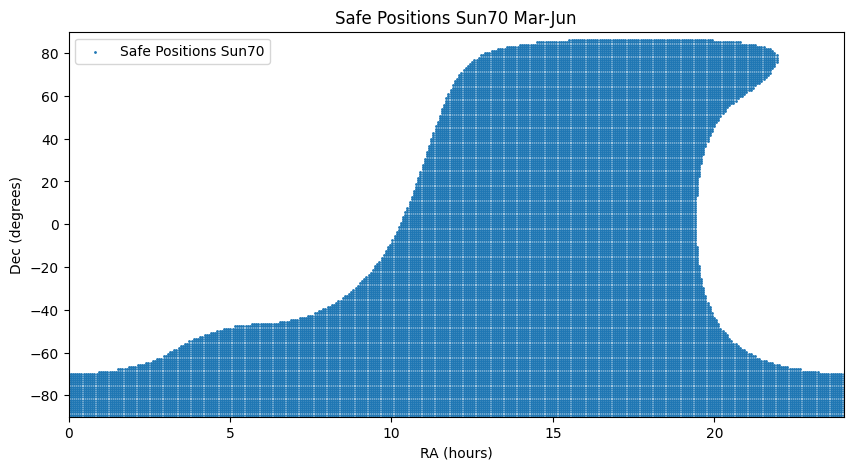

In [28]:
# Main loop to check for safe RA-Dec combinations
safe_coord_24_sun70 = []

for ra in ra_grid:
    for dec in dec_grid:
        is_safe = True
        
        for d in np.arange(0, 23):  # Loop over days
            t = 0  # time step counter
            safe_t = []  # list for the safe time steps
            
            # Apply sun70 constraint
            for sun_ra, sun_dec in sun_daysplit[d]:
                if angular_distance(ra, dec, sun_ra, sun_dec) >= 70:
                    safe_t.append(t)
                t += 1
            
            # If there are fewer than 2 valid time steps, break early
            if len(safe_t) < 2:
                is_safe = False
                break
            
            # Check if there are at least 2 consecutive valid time steps
            if not has_consecutive_times(safe_t, n=2):
                is_safe = False
                break
        
        # If the ra-dec pair is safe for all days, add it to the list
        if is_safe:
            safe_coord_24_sun70.append((ra, dec))
            
safe_ra_24_sun70 = [x[0] for x in safe_coord_24_sun70]
safe_dec_24_sun70 = [y[1] for y in safe_coord_24_sun70]

# Plot the results
plt.figure(figsize=(10, 5))
plt.scatter(safe_ra_24_sun70, safe_dec_24_sun70, s=1, label='Safe Positions Sun70')
plt.xlim(0, 24)
plt.ylim(-90, 90)
plt.xlabel('RA (hours)')
plt.ylabel('Dec (degrees)')
plt.title('Safe Positions Sun70 Mar-Jun')
plt.legend()
plt.show()

#plt.savefig('all_3m_spring_final', dpi=400)

Now we map that over the SFD98 extinction map:

In [29]:
safe_ra_deg_sun70 = [element * 15 for element in safe_ra_24_sun70]

safe_coord_deg_sun70 = list(zip(safe_ra_deg_sun70, safe_dec_24_sun70)) # Creating a new list where both RA and Dec are in degrees

<Figure size 1000x500 with 0 Axes>

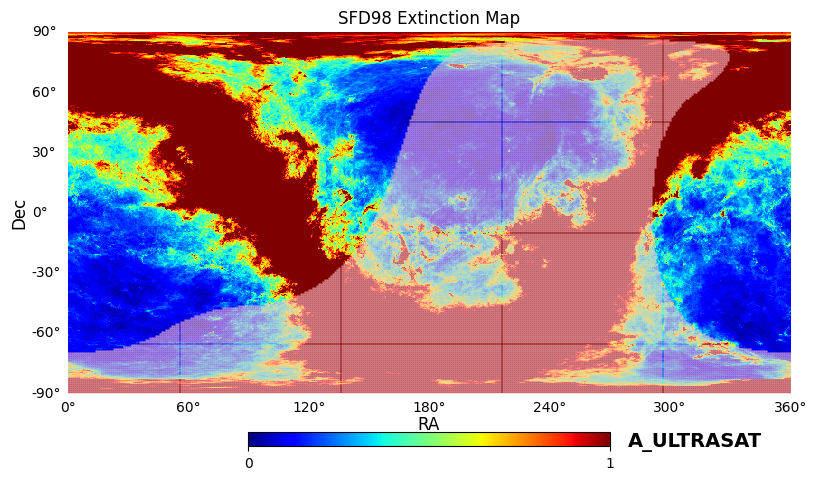

In [45]:
# Convert RA/Dec (theta, phi) to Healpy pixel indices
safe_dec_nparray_sun70 = np.array(safe_dec_24_sun70) # Converting the Dec points into np.array
safe_dec_nparray_sun70 = -safe_dec_nparray_sun70 # Inverting at the x axis, to match the new coordinate system
safe_ra_nparray_sun70 = np.array(safe_ra_deg_sun70) # Converting the RA points into an np.array
ra_data_wrapped_sun70 = safe_ra_nparray_sun70 -180 # Switching to a system where RA ranges from -180° to 180°
ra_data_wrapped_sun70 = -ra_data_wrapped_sun70 # Inverting at the y axis because we also need to flip the other data later on

# Plot the overlapped map using `cartview` in Equatorial coordinates
fig = plt.figure(figsize=(10, 5))

# Plot the SFD98 extinction map
hp.cartview(6.7*ebv_map, coord=['G', 'C'], title="SFD98 Extinction Map", cmap='jet', unit='A_ULTRASAT', min=0, max=1, notext=True)

# Flip the plot upside down because for some reason the data is upside down
plt.gca().invert_yaxis()

# I think plot also needs to be flipped along the x-axis
plt.gca().invert_xaxis()

# Overlay your RA/Dec points directly on the map
plt.scatter(ra_data_wrapped_sun70, safe_dec_nparray_sun70, color='pink', alpha=0.4, s=1, marker='o')

# Add labels for RA/Dec if needed
plt.xlabel('Right Ascension [degrees]', fontsize=12)
plt.ylabel('Declination [degrees]', fontsize=12)

# Add manual labels for Right Ascension (x-axis)
plt.text(0.5, -0.1, 'RA', ha='center', fontsize=12, transform=plt.gca().transAxes)

# Add manual labels for Declination (y-axis)
plt.text(-0.08, 0.5, 'Dec', va='center', rotation='vertical', fontsize=12, transform=plt.gca().transAxes)

# Add RA ticks manually
for ra, label in zip([0, 60, 120, 180, 240, 300, 360], ['0°', '60°', '120°', '180°', '240°', '300°', '360°']):
    plt.text(ra/360, -0.05, label, ha='center', transform=plt.gca().transAxes)

# Add Dec ticks manually
for dec, label in zip([-90, -60, -30, 0, 30, 60, 90], ['-90°', '-60°', '-30°', '0°', '30°', '60°', '90°']):
    plt.text(-0.05, (dec+90)/180, label, va='center', transform=plt.gca().transAxes)

# Show the plot
#plt.legend()
plt.show()

__Sun <130__

Now we've got to repeat that for the sun constraint <130 degrees away from the camera.

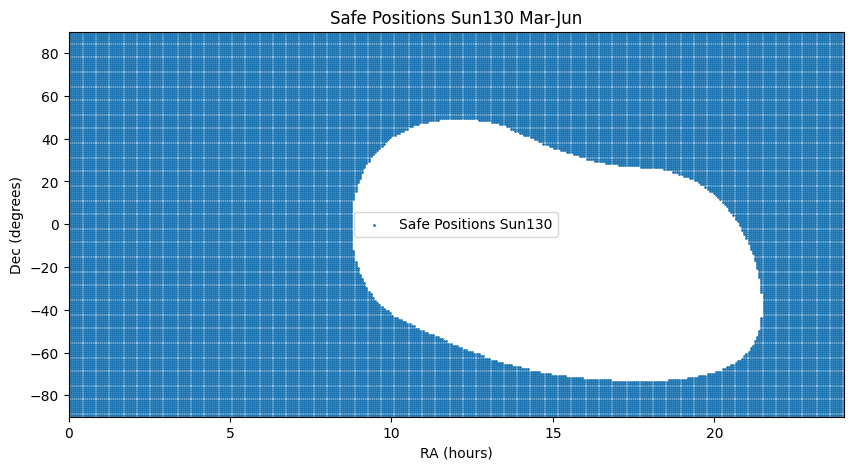

In [31]:
# Main loop to check for safe RA-Dec combinations
safe_coord_24_sun130 = []

for ra in ra_grid:
    for dec in dec_grid:
        is_safe = True
        
        for d in np.arange(0, 23):  # Loop over days
            t = 0  # time step counter
            safe_t = []  # list for the safe time steps
            
            # Apply sun130 constraint
            for sun_ra, sun_dec in sun_daysplit[d]:
                if angular_distance(ra, dec, sun_ra, sun_dec) <= 130:
                    safe_t.append(t)
                t += 1
            
            # If there are fewer than 2 valid time steps, break early
            if len(safe_t) < 2:
                is_safe = False
                break
            
            # Check if there are at least 2 consecutive valid time steps
            if not has_consecutive_times(safe_t, n=2):
                is_safe = False
                break
        
        # If the ra-dec pair is safe for all days, add it to the list
        if is_safe:
            safe_coord_24_sun130.append((ra, dec))
            
safe_ra_24_sun130 = [x[0] for x in safe_coord_24_sun130]
safe_dec_24_sun130 = [y[1] for y in safe_coord_24_sun130]

# Plot the results
plt.figure(figsize=(10, 5))
plt.scatter(safe_ra_24_sun130, safe_dec_24_sun130, s=1, label='Safe Positions Sun130')
plt.xlim(0, 24)
plt.ylim(-90, 90)
plt.xlabel('RA (hours)')
plt.ylabel('Dec (degrees)')
plt.title('Safe Positions Sun130 Mar-Jun')
plt.legend()
plt.show()

#plt.savefig('all_3m_spring_final', dpi=400)

Now we map that over the SFD98 extinction map:

In [32]:
safe_ra_deg_sun130 = [element * 15 for element in safe_ra_24_sun130]

safe_coord_deg_sun130 = list(zip(safe_ra_deg_sun130, safe_dec_24_sun130)) # Creating a new list where both RA and Dec are in degrees

<Figure size 1000x500 with 0 Axes>

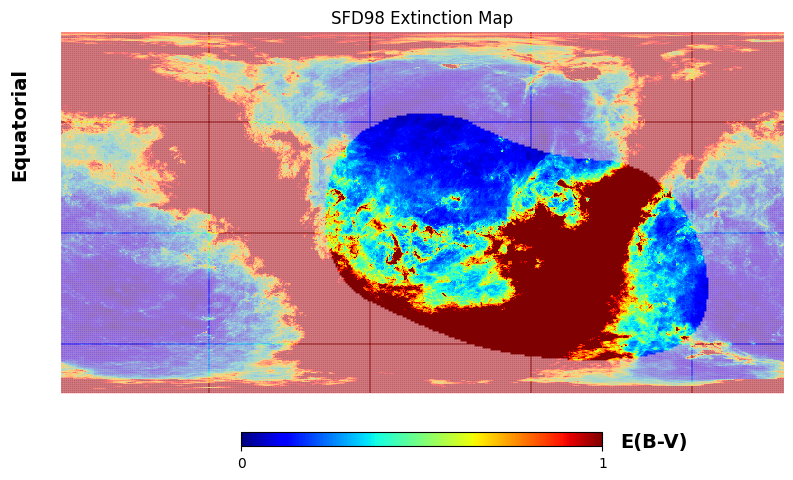

In [33]:
# Convert RA/Dec (theta, phi) to Healpy pixel indices
safe_dec_nparray_sun130 = np.array(safe_dec_24_sun130) # Converting the Dec points into np.array
safe_dec_nparray_sun130 = -safe_dec_nparray_sun130 # Inverting at the x axis, to match the new coordinate system
safe_ra_nparray_sun130 = np.array(safe_ra_deg_sun130) # Converting the RA points into an np.array
ra_data_wrapped_sun130 = safe_ra_nparray_sun130 -180 # Switching to a system where RA ranges from -180° to 180°
ra_data_wrapped_sun130 = -ra_data_wrapped_sun130 # Inverting at the y axis because we also need to flip the other data later on

# Plot the overlapped map using `cartview` in Equatorial coordinates
fig = plt.figure(figsize=(10, 5))

# Plot the SFD98 extinction map
hp.cartview(6.7*ebv_map, coord=['G', 'C'], title="SFD98 Extinction Map", cmap='jet', unit='A_ULTRASAT', min=0, max=1, notext=True)

# Flip the plot upside down because for some reason the data is upside down
plt.gca().invert_yaxis()

# I think plot also needs to be flipped along the x-axis
plt.gca().invert_xaxis()

# Overlay your RA/Dec points directly on the map
plt.scatter(ra_data_wrapped_sun130, safe_dec_nparray_sun130, color='pink', alpha=0.4, s=1, marker='o')

# Add labels for RA/Dec if needed
plt.xlabel('Right Ascension [degrees]', fontsize=12)
plt.ylabel('Declination [degrees]', fontsize=12)

# Add manual labels for Right Ascension (x-axis)
plt.text(0.5, -0.1, 'RA', ha='center', fontsize=12, transform=plt.gca().transAxes)

# Add manual labels for Declination (y-axis)
plt.text(-0.08, 0.5, 'Dec', va='center', rotation='vertical', fontsize=12, transform=plt.gca().transAxes)

# Add RA ticks manually
for ra, label in zip([0, 60, 120, 180, 240, 300, 360], ['0°', '60°', '120°', '180°', '240°', '300°', '360°']):
    plt.text(ra/360, -0.05, label, ha='center', transform=plt.gca().transAxes)

# Add Dec ticks manually
for dec, label in zip([-90, -60, -30, 0, 30, 60, 90], ['-90°', '-60°', '-30°', '0°', '30°', '60°', '90°']):
    plt.text(-0.05, (dec+90)/180, label, va='center', transform=plt.gca().transAxes)

# Show the plot
#plt.legend()
plt.show()

__Sun Combined__

Now I also want to combine the two constraints such that we have an angular distance between 70° and 130°:

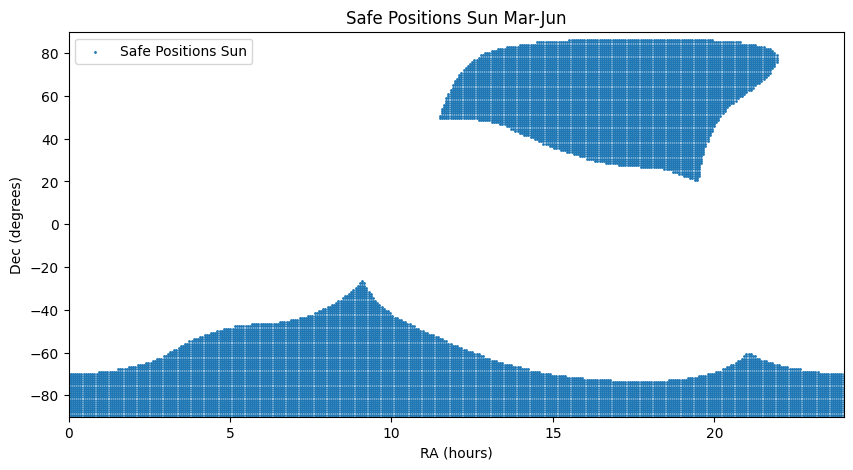

In [34]:
# Main loop to check for safe RA-Dec combinations
safe_coord_24_suncomb = []

for ra in ra_grid:
    for dec in dec_grid:
        is_safe = True
        
        for d in np.arange(0, 23):  # Loop over days
            t = 0  # time step counter
            safe_t = []  # list for the safe time steps
            
            # Apply suncomb constraint
            for sun_ra, sun_dec in sun_daysplit[d]:
                if 70 <= angular_distance(ra, dec, sun_ra, sun_dec) <= 130:
                    safe_t.append(t)
                t += 1
            
            # If there are fewer than 2 valid time steps, break early
            if len(safe_t) < 2:
                is_safe = False
                break
            
            # Check if there are at least 2 consecutive valid time steps
            if not has_consecutive_times(safe_t, n=2):
                is_safe = False
                break
        
        # If the ra-dec pair is safe for all days, add it to the list
        if is_safe:
            safe_coord_24_suncomb.append((ra, dec))
            
safe_ra_24_suncomb = [x[0] for x in safe_coord_24_suncomb]
safe_dec_24_suncomb = [y[1] for y in safe_coord_24_suncomb]

# Plot the results
plt.figure(figsize=(10, 5))
plt.scatter(safe_ra_24_suncomb, safe_dec_24_suncomb, s=1, label='Safe Positions Sun')
plt.xlim(0, 24)
plt.ylim(-90, 90)
plt.xlabel('RA (hours)')
plt.ylabel('Dec (degrees)')
plt.title('Safe Positions Sun Mar-Jun')
plt.legend()
plt.show()

#plt.savefig('all_3m_spring_final', dpi=400)

Now we want to map this over the SFD98 extinction map:

In [35]:
safe_ra_deg_suncomb = [element * 15 for element in safe_ra_24_suncomb]

safe_coord_deg_suncomb = list(zip(safe_ra_deg_suncomb, safe_dec_24_suncomb)) # Creating a new list where both RA and Dec are in degrees

<Figure size 1000x500 with 0 Axes>

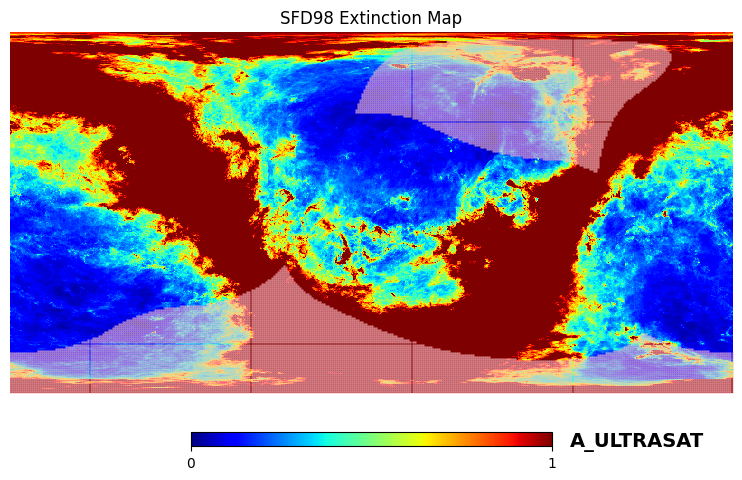

In [36]:
# Convert RA/Dec (theta, phi) to Healpy pixel indices
safe_dec_nparray_suncomb = np.array(safe_dec_24_suncomb) # Converting the Dec points into np.array
safe_dec_nparray_suncomb = -safe_dec_nparray_suncomb # Inverting at the x axis, to match the new coordinate system
safe_ra_nparray_suncomb = np.array(safe_ra_deg_suncomb) # Converting the RA points into an np.array
ra_data_wrapped_suncomb = safe_ra_nparray_suncomb -180 # Switching to a system where RA ranges from -180° to 180°
ra_data_wrapped_suncomb = -ra_data_wrapped_suncomb # Inverting at the y axis because we also need to flip the other data later on

# Plot the overlapped map using `cartview` in Equatorial coordinates
fig = plt.figure(figsize=(10, 5))

# Plot the SFD98 extinction map
hp.cartview(6.7*ebv_map, coord=['G', 'C'], title="SFD98 Extinction Map", cmap='jet', unit='A_ULTRASAT', min=0, max=1, notext=True)

# Flip the plot upside down because for some reason the data is upside down
plt.gca().invert_yaxis()

# I think plot also needs to be flipped along the x-axis
plt.gca().invert_xaxis()

# Overlay your RA/Dec points directly on the map
plt.scatter(ra_data_wrapped_suncomb, safe_dec_nparray_suncomb, color='pink', alpha=0.4, s=1, marker='o')

# Add labels for RA/Dec if needed
plt.xlabel('Right Ascension [degrees]', fontsize=12)
plt.ylabel('Declination [degrees]', fontsize=12)

# Show the plot
#plt.legend()
plt.show()

__Earth__

Finally we do the same things for the Earth constraint

In [12]:
#Trajectory for the earth observed from the satellite
for i in np.arange(3,7): # from March til June
    var = f'd_{i}'
    var_2 = globals()[var]
    for d in var_2:
        for h in np.arange(0,24):
            for m in np.arange(0,60,30):
                t = ts.utc(2024, i, d, h, m)
                astrometric = (earth + satellite_ideal).at(t).observe(earth)
                ra, dec, distance = astrometric.radec()
                earth_eq_values_24.append((ra.hours, dec.degrees))
        t = ts.utc(2024, i, d, 23, 59)
        astrometric = astrometric = (earth + satellite_ideal).at(t).observe(earth)
        ra, dec, distance = astrometric.radec()
        earth_eq_values_24.append((ra.hours, dec.degrees))

A little test, to see what the minimum/maximum apparent angular distance traversed by the earth between two thrirty minute steps is as seen from the satellite:

In [13]:
# Initialize variables to track max/min values and their indices
max_distance = -np.inf
min_distance = np.inf
max_pair = None
min_pair = None

# Iterate through adjacent tuples while skipping the comparison between last step of one day and first step of another day
for i in range(len(earth_eq_values_24) - 1):
    # Determine if the current pair crosses a 49-tuple boundary
    if (i + 1) % 49 == 0:
        continue  # Skip comparison if it's at the boundary between two days
    
    ra1, dec1 = earth_eq_values_24[i]
    ra2, dec2 = earth_eq_values_24[i + 1]
    distance = angular_distance(ra1, dec1, ra2, dec2)

    # Update maximum and minimum values and their pairs
    if distance > max_distance:
        max_distance = distance
        max_pair = (earth_eq_values_24[i], earth_eq_values_24[i + 1])
    if distance < min_distance:
        min_distance = distance
        min_pair = (earth_eq_values_24[i], earth_eq_values_24[i + 1])

# Output results
print(f"Maximum angular distance: {max_distance} between pairs {max_pair}")
print(f"Minimum angular distance: {min_distance} between pairs {min_pair}")

Maximum angular distance: 7.5021625288442 between pairs ((np.float64(22.14187803257982), np.float64(-0.11871544419344625)), (np.float64(22.6420231794854), np.float64(-0.12453237610949859)))
Minimum angular distance: 7.25015960989129 between pairs ((np.float64(14.482372115522157), np.float64(0.09464998762290427)), (np.float64(14.96571588223908), np.float64(0.0816172884694637)))


In [38]:
earth_daysplit = [earth_eq_values_24[i:i + day_size] for i in range(0, len(earth_eq_values_24), day_size)]

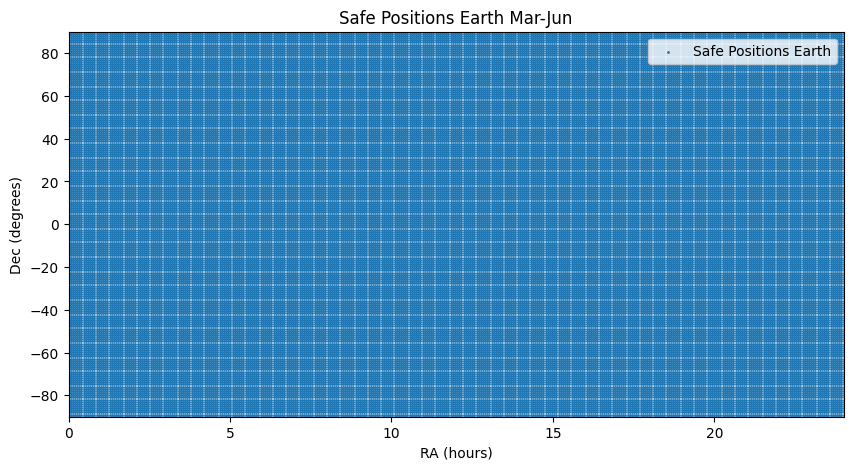

In [39]:
# Main loop to check for safe RA-Dec combinations
safe_coord_24_earth = []

for ra in ra_grid:
    for dec in dec_grid:
        is_safe = True
        
        for d in np.arange(0, 23):  # Loop over days
            t = 0  # time step counter
            safe_t = []  # list for the safe time steps
            
            # Apply earth constraint
            for earth_ra, earth_dec in earth_daysplit[d]:
                if angular_distance(ra, dec, earth_ra, earth_dec) >= 48:
                    safe_t.append(t)
                t += 1
            
            # If there are fewer than 2 valid time steps, break early
            if len(safe_t) < 2:
                is_safe = False
                break
            
            # Check if there are at least 2 consecutive valid time steps
            if not has_consecutive_times(safe_t, n=2):
                is_safe = False
                break
        
        # If the ra-dec pair is safe for all days, add it to the list
        if is_safe:
            safe_coord_24_earth.append((ra, dec))
            
safe_ra_24_earth = [x[0] for x in safe_coord_24_earth]
safe_dec_24_earth = [y[1] for y in safe_coord_24_earth]

# Plot the results
plt.figure(figsize=(10, 5))
plt.scatter(safe_ra_24_earth, safe_dec_24_earth, s=1, label='Safe Positions Earth')
plt.xlim(0, 24)
plt.ylim(-90, 90)
plt.xlabel('RA (hours)')
plt.ylabel('Dec (degrees)')
plt.title('Safe Positions Earth Mar-Jun')
plt.legend()
plt.show()

#plt.savefig('all_3m_spring_final', dpi=400)

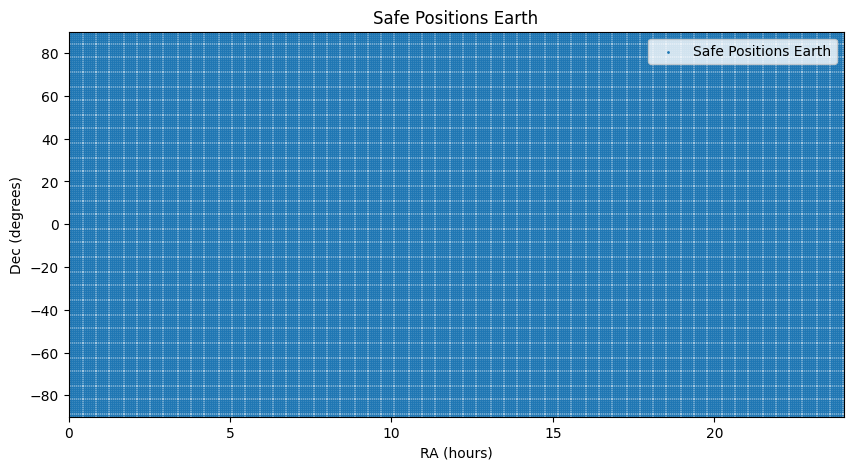

In [40]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.scatter(safe_ra_24_earth, safe_dec_24_earth, s=1, label='Safe Positions Earth')
plt.xlim(0, 24)
plt.ylim(-90, 90)
plt.xlabel('RA (hours)')
plt.ylabel('Dec (degrees)')
plt.title('Safe Positions Earth')
plt.legend()
plt.show()

Now we map that over the SFD98 extinction map:

In [41]:
safe_ra_deg_earth = [element * 15 for element in safe_ra_24_earth]

safe_coord_deg_earth = list(zip(safe_ra_deg_earth, safe_dec_24_earth)) # Creating a new list where both RA and Dec are in degrees

/tmp/ipykernel_44436/1526352630.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1000x500 with 0 Axes>

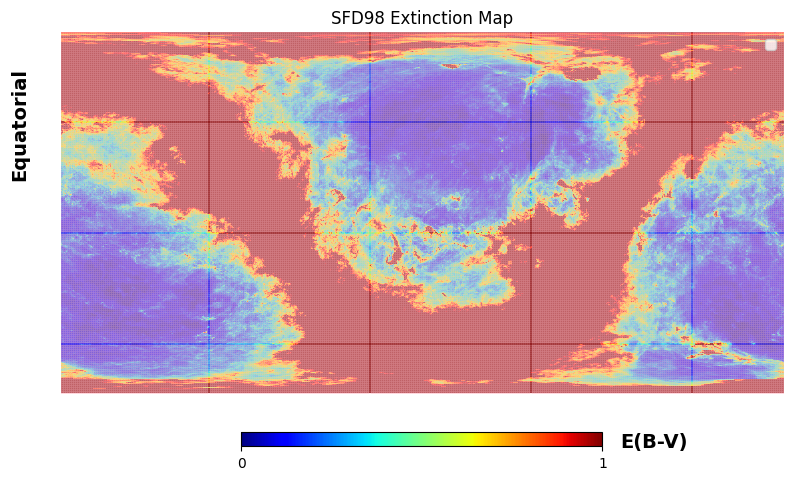

In [42]:
# Convert RA/Dec (theta, phi) to Healpy pixel indices
safe_dec_nparray_earth = np.array(safe_dec_24_earth) # Converting the Dec points into np.array
safe_dec_nparray_earth = -safe_dec_nparray_earth # Inverting at the x axis, to match the new coordinate system
safe_ra_nparray_earth = np.array(safe_ra_deg_earth) # Converting the RA points into an np.array
ra_data_wrapped_earth = safe_ra_nparray_earth -180 # Switching to a system where RA ranges from -180° to 180°
ra_data_wrapped_earth = -ra_data_wrapped_earth # Inverting at the y axis because we also need to flip the other data later on

# Plot the overlapped map using `cartview` in Equatorial coordinates
fig = plt.figure(figsize=(10, 5))

# Plot the SFD98 extinction map
hp.cartview(6.7*ebv_map, coord=['G', 'C'], title="SFD98 Extinction Map", cmap='jet', unit='A_ULTRASAT', min=0, max=1, notext=True)

# Flip the plot upside down because for some reason the data is upside down
plt.gca().invert_yaxis()

# I think plot also needs to be flipped along the x-axis
plt.gca().invert_xaxis()

# Overlay your RA/Dec points directly on the map
plt.scatter(ra_data_wrapped_earth, safe_dec_nparray_earth, color='pink', alpha=0.4, s=1, marker='o')

# Add labels for RA/Dec if needed
plt.xlabel('Right Ascension [degrees]', fontsize=12)
plt.ylabel('Declination [degrees]', fontsize=12)

# Add manual labels for Right Ascension (x-axis)
plt.text(0.5, -0.1, 'RA', ha='center', fontsize=12, transform=plt.gca().transAxes)

# Add manual labels for Declination (y-axis)
plt.text(-0.08, 0.5, 'Dec', va='center', rotation='vertical', fontsize=12, transform=plt.gca().transAxes)

# Add RA ticks manually
for ra, label in zip([0, 60, 120, 180, 240, 300, 360], ['0°', '60°', '120°', '180°', '240°', '300°', '360°']):
    plt.text(ra/360, -0.05, label, ha='center', transform=plt.gca().transAxes)

# Add Dec ticks manually
for dec, label in zip([-90, -60, -30, 0, 30, 60, 90], ['-90°', '-60°', '-30°', '0°', '30°', '60°', '90°']):
    plt.text(-0.05, (dec+90)/180, label, va='center', transform=plt.gca().transAxes)

# Show the plot
plt.legend()
plt.show()